In [1]:
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import numpy as np
from fairlearn.datasets import fetch_acs_income
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier #continuous values?


## Binary classification

In [2]:
data = fetch_acs_income()
# convert to df
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
 # I'm not sure what this feature even is cause I can't  find anything about it in the documenation so I'm leaving it oout for now
df = df.drop(columns=['ST'], errors='ignore')

print(df.head())

   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P   target
0  18.0  1.0  18.0  5.0  4720.0  13.0  17.0  21.0  2.0    2.0   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  16.0  40.0  1.0    1.0  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  17.0  40.0  1.0    1.0  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0  17.0   2.0  2.0    1.0    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  17.0  50.0  1.0    1.0  29000.0


### Data Analysis

In [3]:
df.isna().sum()

AGEP      0
COW       0
SCHL      0
MAR       0
OCCP      0
POBP      0
RELP      0
WKHP      0
SEX       0
RAC1P     0
target    0
dtype: int64

In [4]:
df['OCCP'].value_counts().sort_index()


OCCP
10.0      14296
20.0      10186
40.0        563
51.0       5548
52.0       4601
          ...  
9760.0      803
9800.0      413
9810.0      794
9825.0     1993
9830.0     2504
Name: count, Length: 529, dtype: int64

In [5]:
numeric_cols = ['AGEP', 'WKHP']
categorical_cols = ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX',  'RAC1P'] 

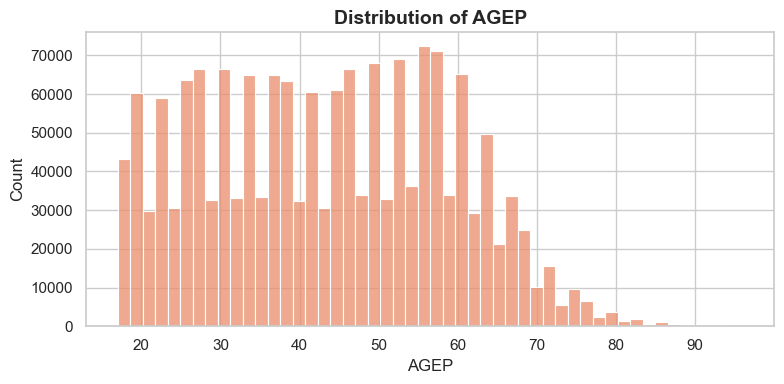

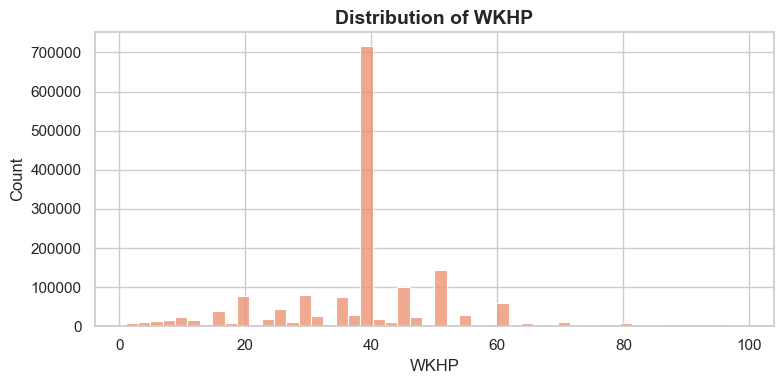

In [6]:

sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


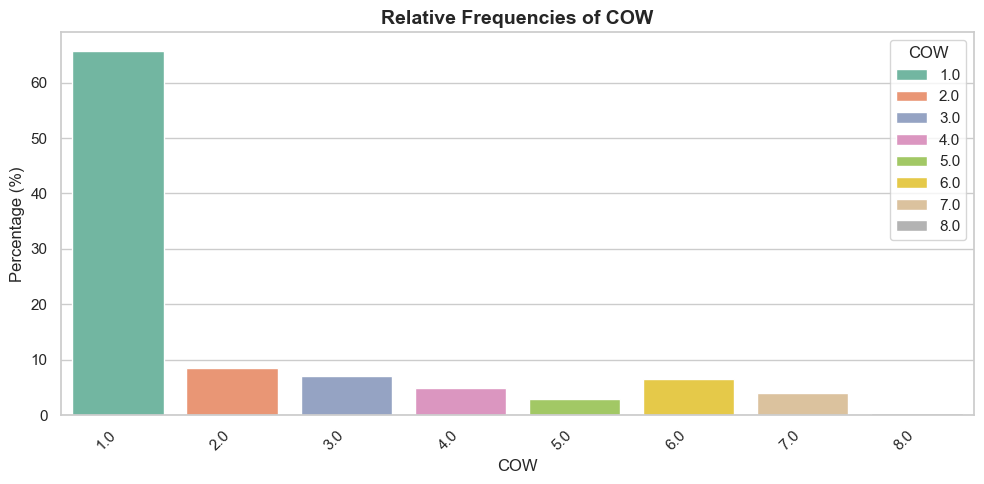

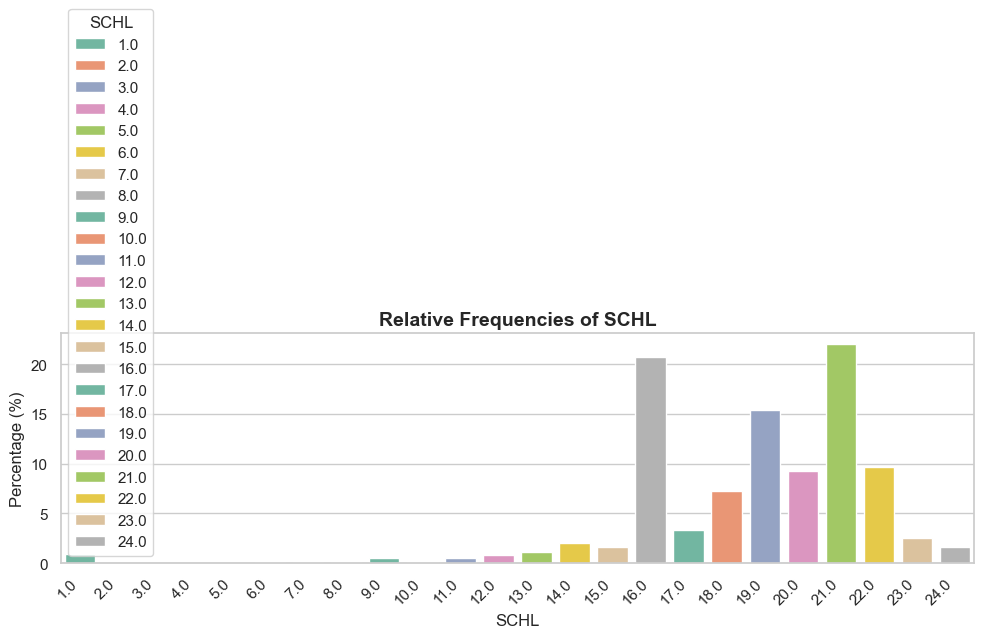

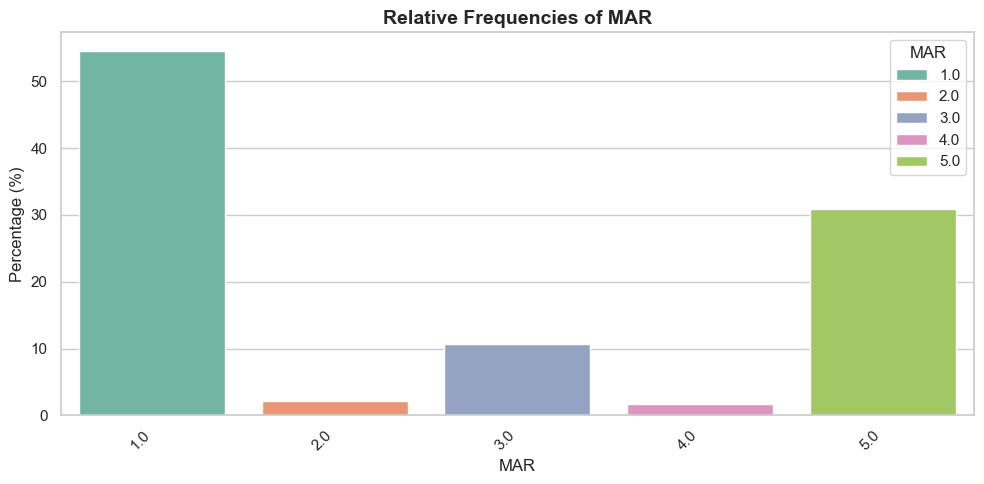

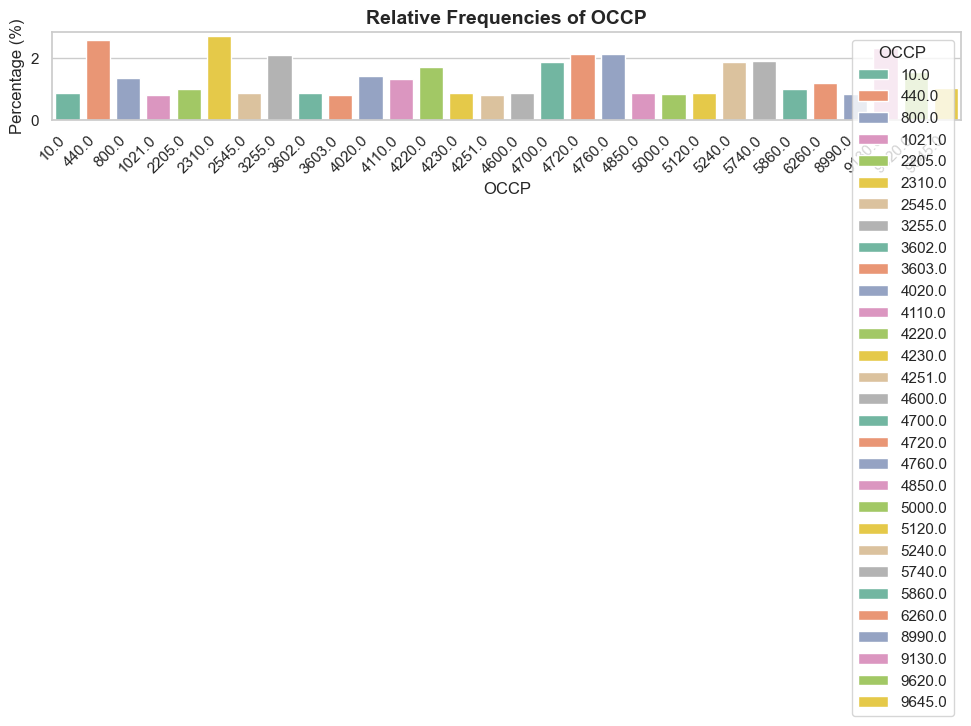

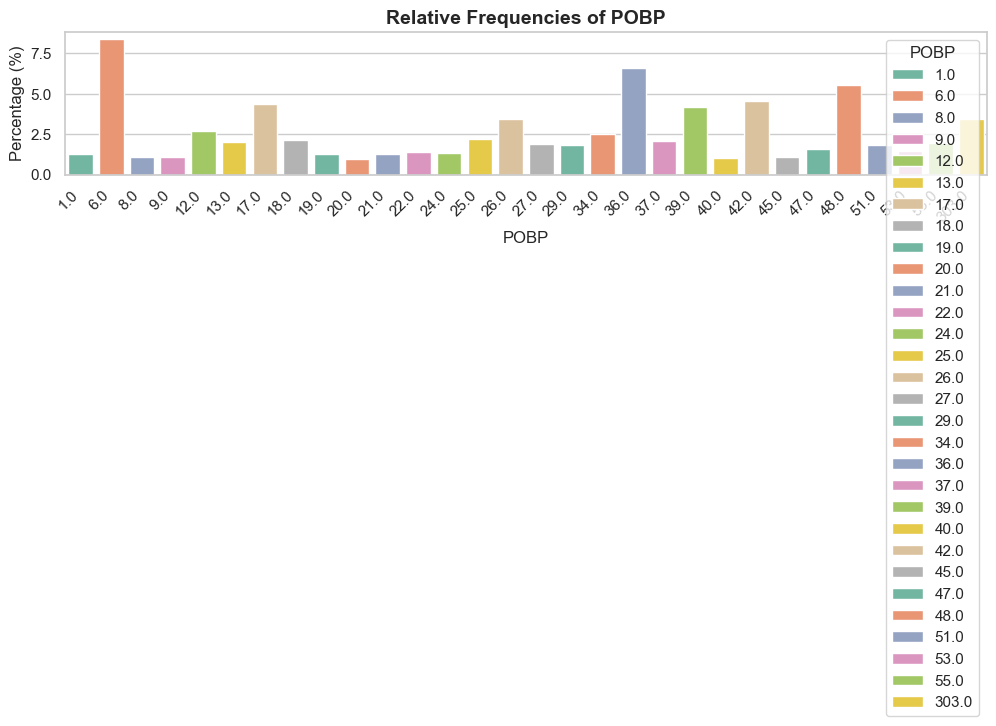

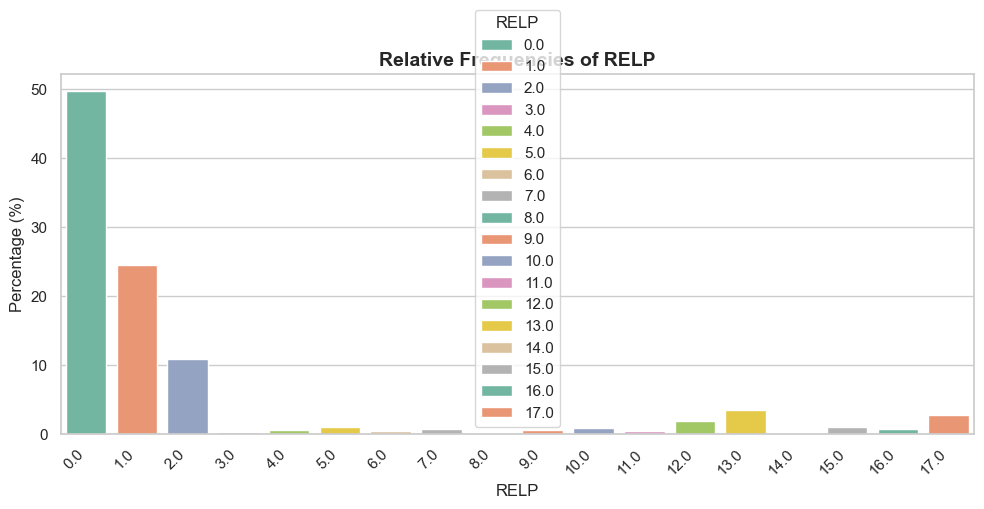

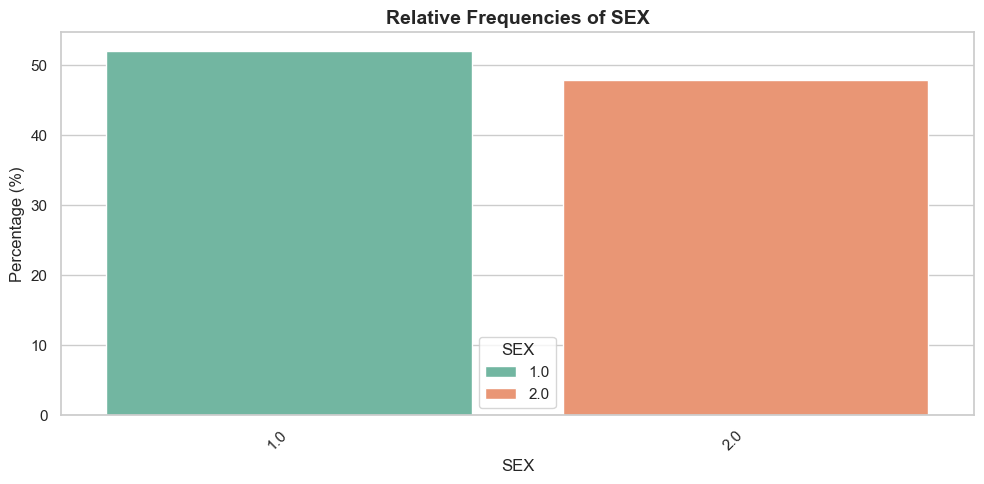

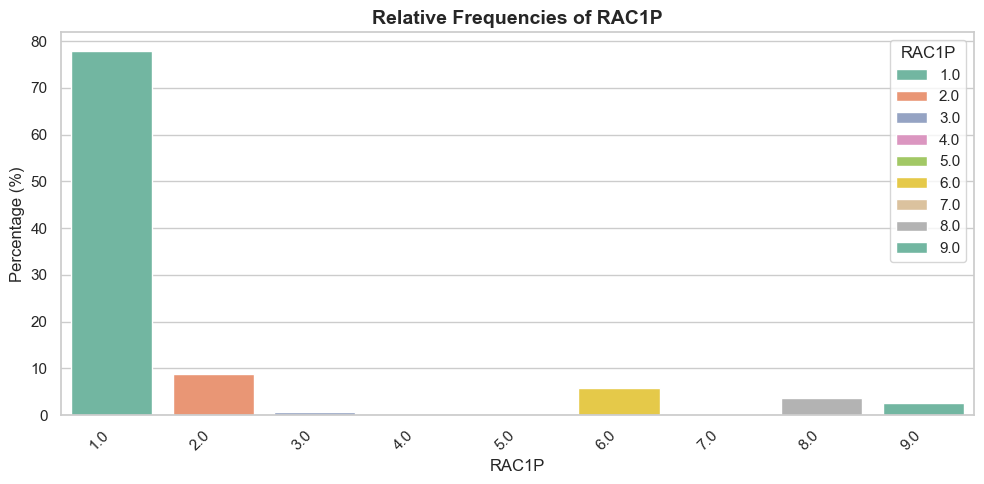

In [7]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = df[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Pre-processing

In [8]:
# potential approaches #
# Age clustering
# removing certain subgroups from OCCP, POBP

### Creating thresholds and splitting datasets

In [9]:

def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    return X, y


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(df, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_val_enc   = preprocessor.transform(X_val)
X_test_enc  = preprocessor.transform(X_test)


In [10]:
y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [11]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(ohe_feature_names) + numeric_cols

### Linear baseline model for performance comparison 
### **DO NOT RUN takes ages**

In [12]:
# logreg = LogisticRegression(solver= 'saga', class_weight='balanced', max_iter=2500)
# logreg.fit(X_train_enc, y_train)
# y_pred_logreg = logreg.predict(X_test_enc)
# print(classification_report(y_test, y_pred_logreg))


### **XGBoostClassifier** - Hyperparameter tuning with random grid search

In [13]:
'''
param_dist = {
    'n_estimators': randint(100, 700),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

n_iter = 20
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
results = []

for i, params in enumerate(param_list):
    print(f"\n Running trial {i+1}/{n_iter}...")
    print("Params:", params)
    start = time.time()

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        **params
    )

    model.fit(X_train_enc, y_train)
    y_val_pred = model.predict(X_val_enc)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    duration = time.time() - start
    print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

    results.append((params, val_f1))

# Get best model
best_params, best_score = max(results, key=lambda x: x[1])
print("\nBest Hyperparameters:", best_params)
print(f"Best Validation F1 (macro): {best_score:.4f}")

# Train best model on full training data
best_model = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)
best_model.fit(X_train_enc, y_train)

# Final test evaluation
y_test_pred = best_model.predict(X_test_enc)
print("\n Final Test Set Performance:")
print(classification_report(y_test, y_test_pred))
'''


'\nparam_dist = {\n    \'n_estimators\': randint(100, 700),\n    \'max_depth\': randint(3, 15),\n    \'learning_rate\': uniform(0.01, 0.3),\n    \'subsample\': uniform(0.5, 0.5),\n    \'colsample_bytree\': uniform(0.5, 0.5),\n    \'gamma\': uniform(0, 5),\n    \'reg_alpha\': uniform(0, 1),\n    \'reg_lambda\': uniform(0, 1),\n}\n\nn_iter = 20\nparam_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))\nresults = []\n\nfor i, params in enumerate(param_list):\n    print(f"\n Running trial {i+1}/{n_iter}...")\n    print("Params:", params)\n    start = time.time()\n\n    model = XGBClassifier(\n        use_label_encoder=False,\n        eval_metric=\'logloss\',\n        n_jobs=-1,\n        **params\n    )\n\n    model.fit(X_train_enc, y_train)\n    y_val_pred = model.predict(X_val_enc)\n    val_f1 = f1_score(y_val, y_val_pred, average=\'macro\')\n\n    duration = time.time() - start\n    print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {durat

### TreeSHAP

In [12]:
# run ONLY IF you didn't run the previous code block

best_params = {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': np.float64(0.5247746602583891), 'reg_lambda': np.float64(0.3998609717152555), 'subsample': np.float64(0.5233328316068078)}

best_model = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)
best_model.fit(X_train_enc, y_train)

explainer = shap.Explainer(best_model, feature_names = all_feature_names)


In [13]:
def rename_features(shap_values):
    custom_names = {
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1.0': 'Male',
    'SEX_2.0': 'Female',
    'RELP_0.0': 'Householder',
    'SCHL_21.0': 'Bachelors Degree',
    'SCHL_22.0': 'Masters Degree',
    'SCHL_23.0': 'Professional degree beyond a bachelos degree',
    'MAR_1.0': 'Married',
    'MAR_5.0': 'Never Married',
    'OCCP_3255.0': 'Occupation: Registered Nurse',
    'RELP_1.0': 'Husband/Wife of Householder',
    'RAC1P_2.0': 'Black or African American alone',
    'RAC1P_1.0': 'White alone'
    }
    renamed_features = [
        custom_names.get(name, name)
        for name in shap_values.feature_names
    ]
    return renamed_features

### White-only SHAP

In [ ]:
white_index = all_feature_names.index('RAC1P_1.0')
white_column = X_test_enc[:, white_index].toarray().ravel()
white_mask = white_column == 1.0
white_alone = X_test_enc[white_mask]

print((white_alone).shape)
shap_values = explainer(white_alone)


(194518, 821)


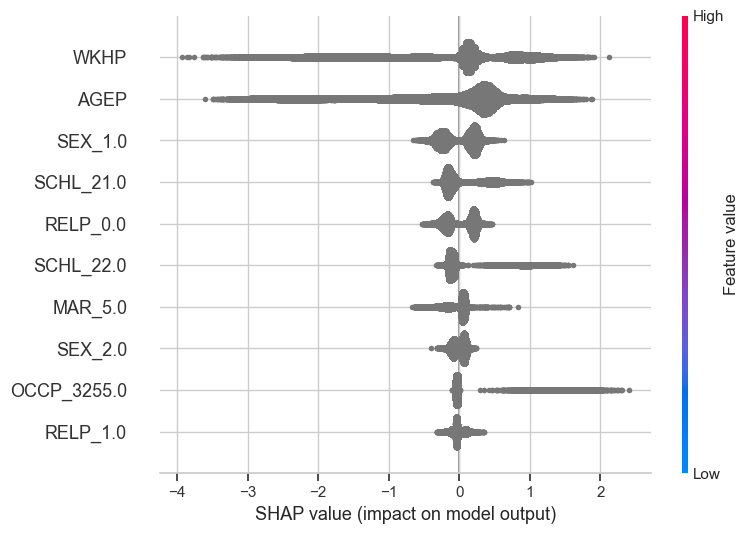

In [ ]:
shap.summary_plot(shap_values, white_alone, max_display=10)

### Black-only SHAP

In [ ]:
black_index = all_feature_names.index('RAC1P_2.0')
black_column = X_test_enc[:, black_index].toarray().ravel()
black_mask = black_column == 1.0
black_or_afam_alone = X_test_enc[black_mask]

black_shap_values = explainer(black_or_afam_alone)
black_shap_values.feature_names = rename_features(black_shap_values)

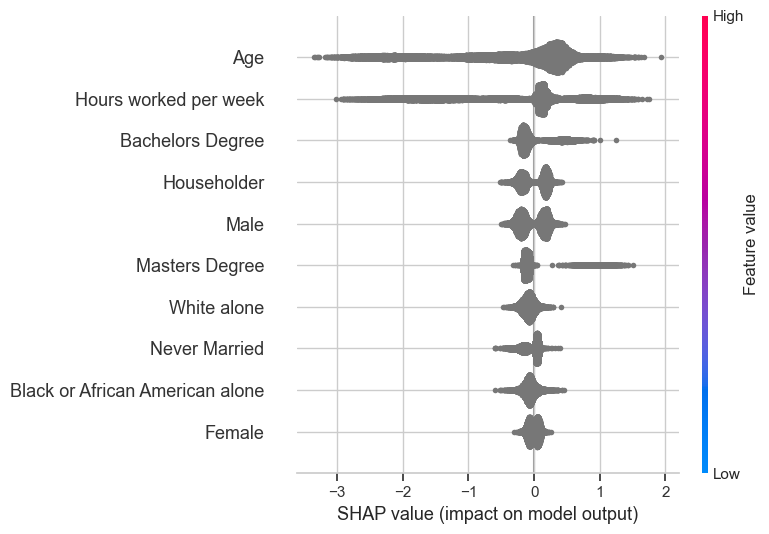

In [ ]:
shap.summary_plot(black_shap_values, black_or_afam_alone, max_display=10)

### Female SHAP

In [ ]:
female_index = all_feature_names.index('SEX_2.0')
female_column = X_test_enc[:, female_index].toarray().ravel()
female_mask = female_column == 1.0
female_X_enc = X_test_enc[female_mask]

female_shap_values = explainer(female_X_enc)
female_shap_values.feature_names = rename_features(female_shap_values)

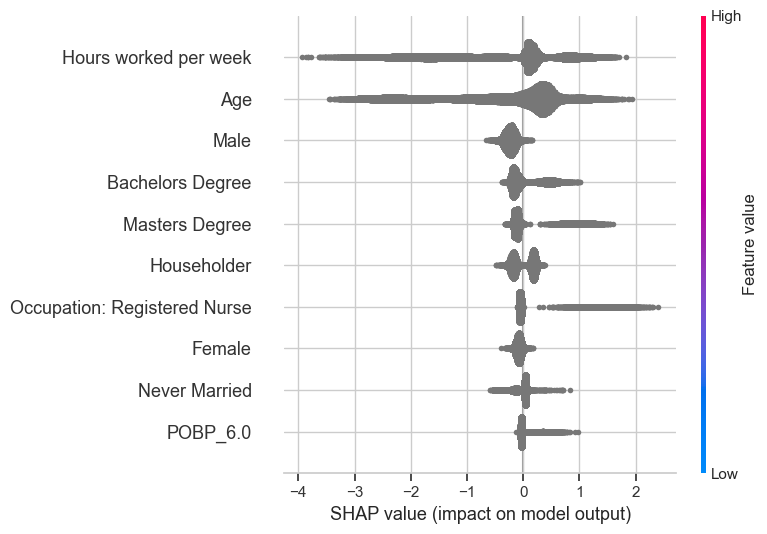

In [ ]:
shap.summary_plot(female_shap_values, female_X_enc, max_display=10)

### Male SHAP

In [1]:
male_index = all_feature_names.index('SEX_1.0')
male_column = X_test_enc[:, male_index].toarray().ravel()
male_mask = male_column == 1.0
male_X_enc = X_test_enc[male_mask]

male_shap_values = explainer(male_X_enc)
male_shap_values.feature_names = rename_features(male_shap_values)

NameError: name 'all_feature_names' is not defined

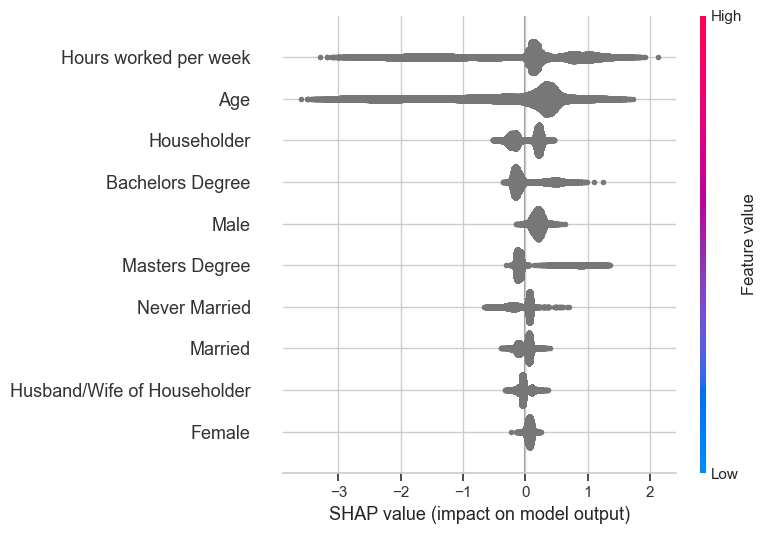

In [ ]:
shap.summary_plot(male_shap_values, male_X_enc, max_display=10)

### All population SHAP

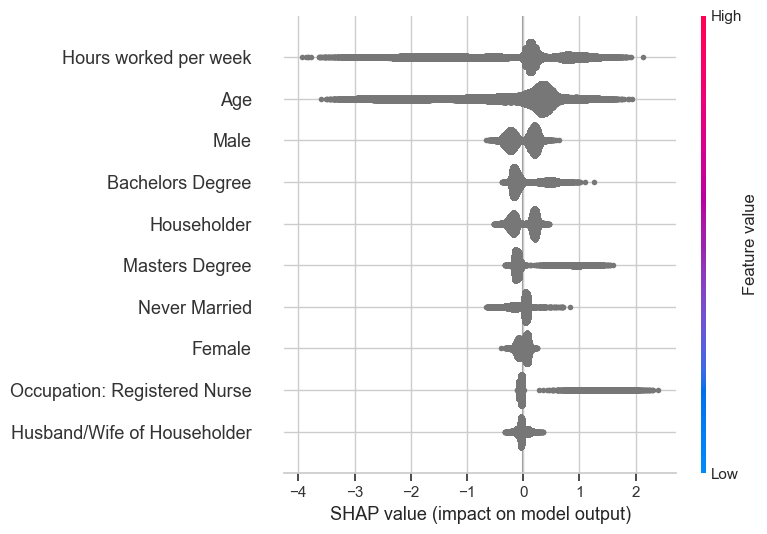

In [14]:
shap_values = explainer(X_test_enc)
shap_values.feature_names = rename_features(shap_values)
shap.summary_plot(shap_values, X_test_enc, max_display=10)

### T-test

In [15]:
# effect size is what we need: 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC3444174/

def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [41]:
COW = {1:"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
2:"Employee of a private not-for-profit, tax-exempt, or charitable organization",
3:"Local government employee (city, county, etc.)",
4:"State government employee",
5:"Federal government employee",
6:"Self-employed in own not incorporated business, professional practice, or farm",
7:"Self-employed in own incorporated business, professional practice or farm",
8:"Working without pay in family business or farm",
9:"Unemployed and last worked 5 years ago or earlier or never worked"}
SCHL = {1:"No schooling completed",
2:"Nursery school or preschool",
3:"Kindergarten",
4:"Grade 1",
5:"Grade 2",
6:"Grade 3",
7:"Grade 4",
8:"Grade 5",
9:"Grade 6",
10:"Grade 7",
11:"Grade 8",
12:"Grade 9",
13:"Grade 10",
14:"Grade 11",
15:"Grade 12 (no diploma)",
16:"Regular high school diploma",
17:"GED or alternative credential",
18:"Some college but less than 1 year",
19:"1 or more years of college credit but no degree",
20:"Associate’s degree",
21:"Bachelor’s degree",
22:"Master’s degree",
23:"Professional degree beyond a bachelor’s degree",
24:"Doctorate degree"}
MAR = {1:"Married", 2:"Widowed", 3:"Divorced",4:"Separated",5:"Never married or under 15 years old"}
RELP = {0:"Reference person",
1:"Husband or wife",
2:"Biological son or daughter",
3:"Adopted son or daughter",
4:"Stepson or stepdaughter",
5:"Brother or sister",
6:"Father or mother",
7:"Grandchild",
8:"Parent-in-law",
9:"Son-in-law or daughter-in-law",
10:"Other relative",
11:"Roomer or boarder",
12:"Housemate or roommate",
13:"Unmarried partner",
14:"Foster child",
15:"Other nonrelative",
16:"Institutionalized group quarters population. Includes correctional facilities, nursing homes, and mental hospitals.",
17:"Noninstitutionalized group quarters population. Includes college dormitories, military barracks, group homes, missions, and shelters."}
SEX = {1:"Male", 2:"Female"}
RAC1P = {1:"White alone",
2:"Black or African American alone",
3:"American Indian alone",
4:"Alaska Native alone",
5:"American Indian and Alaska native tribes specified; or American Indian or Alaska Native, not specified and no other races",
6:"Asian alone",
7:"Native Hawaiian and Other Pacific Islander alone",
8:"Some Other Race alone",
9:"Two or More races"}
# numerical: AGEP and WKHP

In [ ]:
from scipy.stats import ttest_ind
print(shap_values.shape)
# example: male v female cauacasian
mask_A = (X_test['SEX'] == 1) & (X_test['RAC1P'] == 1)
mask_B = (X_test['SEX'] == 2) & (X_test['RAC1P'] == 1)

shap_male = shap_values.values[mask_A.values]
shap_female = shap_values.values[mask_B.values]
feature_names = ['COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 
                 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 
                 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_5.0', 
                 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 
                 'SEX_1.0', 'SEX_2.0', 
                 'RAC1P_1.0', 'RAC1P_2.0', 'RAC1P_3.0', 'RAC1P_4.0', 'RAC1P_5.0', 'RAC1P_6.0', 'RAC1P_7.0', 'RAC1P_8.0', 'RAC1P_9.0', 
                 'AGEP', 
                 'WKHP']


t_test_results = []

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    stat, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test to account for variance differences
    try:
        full_feature = feature.split('_')
        target = full_feature[0]
        index = int(float(full_feature[1]))
        if target == "COW":
            full_feature = (COW[index])
        elif target == "SCHL":
            full_feature = (SCHL[index])
        elif target == "MAR":
            full_feature = (MAR[index])
        elif target == "RELP":
            full_feature = (RELP[index])
        elif target == "SEX":
            full_feature = (SEX[index])
        elif target == "RAC1P":
            full_feature = (RAC1P[index])
    except:
        if full_feature == "WKHP":
            full_feature = "working hours per week"
        if full_feature == "AGEP":
            full_feature = "age"
    t_test_results.append({
        'feature': feature,
        'feature description': full_feature,
        't_stat': stat,
        'p_value': pval,
        'effect size': cohend(group1, group2),
        'mean_diff': group1.mean() - group2.mean()
        
    })
# Turn into a DataFrame
t_test_df = pd.DataFrame(t_test_results)

# Sort by p-value for significance
t_test_df = t_test_df.sort_values('effect size')
# Display top differences
print(t_test_df[['feature', 'feature description', 't_stat', 'p_value','effect size','mean_diff']].head(15))



(249675, 821)
      feature                                feature description     t_stat  \
29  SCHL_22.0                                    Master’s degree -23.763686   
23  SCHL_16.0                        Regular high school diploma -16.495857   
53  RELP_16.0  Institutionalized group quarters population. I... -16.107844   
2     COW_3.0     Local government employee (city, county, etc.) -14.723663   
27  SCHL_20.0                                 Associate’s degree -12.692606   
..        ...                                                ...        ...   
37   RELP_0.0                                   Reference person  17.798323   
65  RAC1P_9.0                                  Two or More races  18.053047   
0     COW_1.0  Employee of a private for-profit company or bu...  20.219990   
54  RELP_17.0  Noninstitutionalized group quarters population...  23.593671   
1     COW_2.0  Employee of a private not-for-profit, tax-exem...  33.844072   

          p_value  effect size  mean_

In [59]:
# print the columns of those that have an effect size stronger than 0.1

subset1 = t_test_df[t_test_df['effect size'] > 0.1 ]
subset2 = t_test_df[t_test_df['effect size'] < -0.1 ]
print(subset1)
print(subset2)

      feature                                feature description     t_stat  \
54  RELP_17.0  Noninstitutionalized group quarters population...  23.593671   
1     COW_2.0  Employee of a private not-for-profit, tax-exem...  33.844072   

          p_value  effect size  mean_diff  
54  8.395151e-123     0.102565   0.006643  
1   3.328478e-250     0.156517   0.006358  
      feature feature description     t_stat        p_value  effect size  \
29  SCHL_22.0     Master’s degree -23.763686  1.268568e-124    -0.109502   

    mean_diff  
29  -0.034587  


### **Simple FFNN** - Hyperparameter tuning with random grid search


In [ ]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

In [ ]:
# param_dist = {
#     'hidden_units': [32, 64, 128],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'learning_rate': [1e-2, 1e-3, 1e-4],
#     'batch_size': [32, 64],
#     'epochs': [10, 20]
# }

# def sample_params(param_dist):
#     return {k: np.random.choice(v) for k, v in param_dist.items()}

# n_iter = 10
# input_dim = X_train_enc.shape[1]
# results = []

# cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights = dict(zip(np.unique(y_train), cw))


# for i in range(n_iter):
#     params = sample_params(param_dist)
#     print(f"Trial {i+1}/{n_iter} with params: {params}")

#     model = build_ffnn(
#         input_dim=input_dim,
#         hidden_units=params['hidden_units'],
#         dropout_rate=params['dropout_rate'],
#         learning_rate=params['learning_rate']
#     )

#     model.fit(
#         X_train_enc, y_train,
#         validation_data=(X_val_enc, y_val),
#         epochs=params['epochs'],
#         batch_size=params['batch_size'],
#         verbose=0, 
#         class_weight=class_weights
        
#     )

#     val_preds = model.predict(X_val_enc).ravel()
#     val_auc = roc_auc_score(y_val, val_preds)
#     print(f"Val AUC: {val_auc:.4f}\n")

#     results.append((params, val_auc))

# # Find the best model
# best_params, best_val_auc = max(results, key=lambda x: x[1])
# print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")


In [ ]:
best_params = {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.01), 'batch_size': np.int64(64), 'epochs': np.int64(20)}
n_iter = 10
input_dim = X_train_enc.shape[1]
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), cw))

In [ ]:
# build best model
best_model_NN = build_ffnn(
    input_dim=input_dim,
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model_NN.fit(
    X_train_enc, y_train,
    validation_data=(X_val_enc, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    class_weight=class_weights
)

In [ ]:
best_model_NN.save('best_ffnn_model.keras')

### DeepSHAP

In [ ]:
def rename_deep_shap_features(feature_name_list):
    custom_names = {
        'WKHP': 'Hours worked per week',
        'AGEP': 'Age',
        'SEX_1.0': 'Male',
        'SEX_2.0': 'Female',
        'RELP_0.0': 'Householder',
        'SCHL_21.0': 'Bachelors Degree',
        'SCHL_22.0': 'Masters Degree',
        'SCHL_23.0': 'Professional degree beyond a bachelors degree',
        'MAR_1.0': 'Married',
        'MAR_5.0': 'Never Married',
        'OCCP_3255.0': 'Occupation: Registered Nurse',
        'RELP_1.0': 'Husband/Wife of Householder',
        'RELP_2.0': 'Biological Son/Daughtor of Householder',
        'RAC1P_2.0': 'Black or African American alone',
        'RAC1P_1.0': 'White alone'
    }

    renamed_features = [custom_names.get(name, name) for name in feature_name_list]
    return renamed_features


c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(5000, 821))']
  warnings.warn(msg)
c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(10000, 821))']
  warnings.warn(msg)


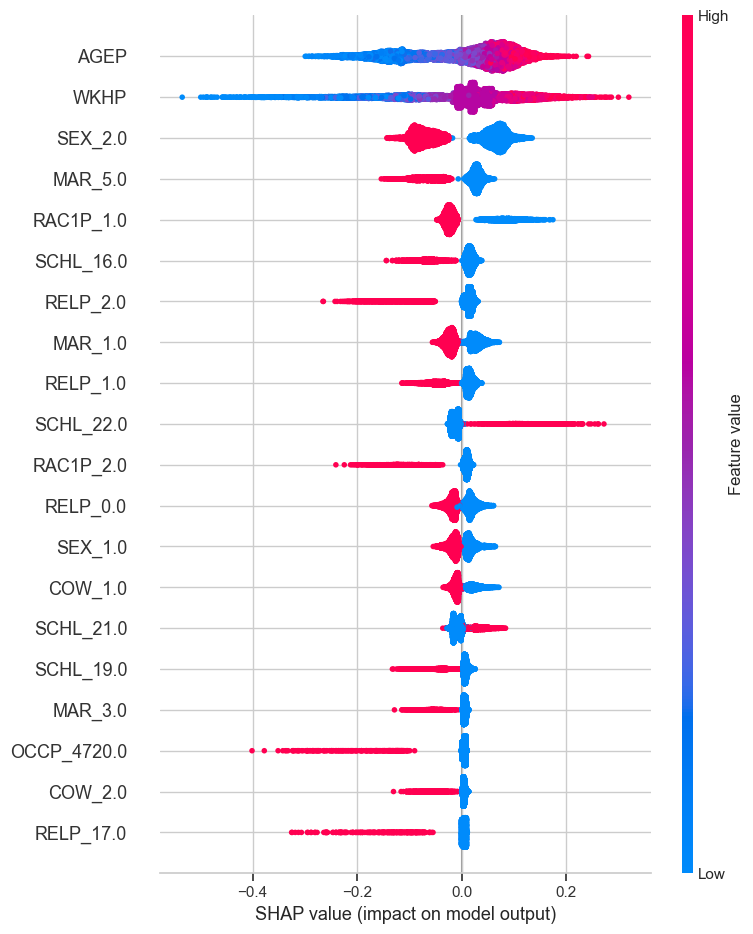

In [ ]:
# sample representative background set and sample size
background_size = 5000 
test_sample_size = 10000

# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_enc, y_train))

# stratified sample from test set
X_test_array = X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx = next(sss_test.split(X_test_array, y_test))
X_test_sample = X_test_array[test_sample_idx]

# set background 
background = X_train_enc[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background

# DeepSHAP
explainer = shap.DeepExplainer(best_model_NN, background)
deep_shap_values = explainer.shap_values(X_test_sample).squeeze(-1)

np.save('deep_shap_values.csv', deep_shap_values)
shap.summary_plot(deep_shap_values, X_test_sample, feature_names=all_feature_names, max_display=20)

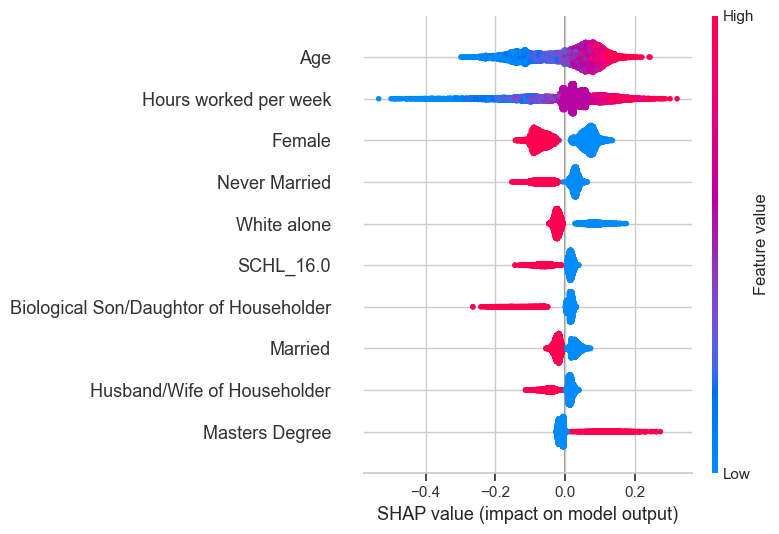

In [35]:
renamed_feature_names = rename_deep_shap_features(all_feature_names)

shap.summary_plot(deep_shap_values, X_test_sample, feature_names=renamed_feature_names, max_display=10)

# SHAP value analysis between subgroups: NOT USED YET

In [ ]:
# shap compatibility
X_train = X_train.astype(float)
X_test = X_test.astype(float)

: 

In [ ]:
# use TreeSHAP
explainer = shap.TreeExplainer(best_model, X_train)

# SHAP values for test set
shap_values = explainer(X_test)

100%|===================| 249606/249675 [114:08<00:01]        

In [ ]:
#  base values and shap values
shap_matrix = np.array([sv.values for sv in shap_values])  # shape: [n_samples, n_features]

# put shap values with the original test set
shap_df = pd.DataFrame(shap_matrix, columns=X_test.columns)
shap_df['RAC1P'] = results['RAC1P']
shap_df['SEX'] = results['SEX']
shap_df['true'] = results['true']
shap_df['pred'] = results['pred']
shap_df['correct'] = np.isclose(shap_df['true'], shap_df['pred'], atol=10000)  # example tolerance

In [ ]:

group = (shap_df['RAC1P'] == 1) 
correct = shap_matrix[group & shap_df['correct']]
incorrect = shap_matrix[group & (~shap_df['correct'])]

# aggregate mean vectors
mean_correct = np.mean(correct, axis=0)
mean_incorrect = np.mean(incorrect, axis=0)

#  distance metrics
cosine_dist = cosine(mean_correct, mean_incorrect)
l2_dist = euclidean(mean_correct, mean_incorrect)

to do: make efficient script to go through all distances

In [ ]:
mean_white = np.mean(shap_matrix[shap_df['RAC1P'] == 1], axis=0)
mean_black = np.mean(shap_matrix[shap_df['RAC1P'] == 2], axis=0)

cosine_dist_group = cosine(mean_white, mean_black)
l2_dist_group = euclidean(mean_white, mean_black)

In [ ]:
mean_white = np.mean(shap_matrix[shap_df['RAC1P'] == 1], axis=0)
mean_asian = np.mean(shap_matrix[shap_df['RAC1P'] == 6], axis=0)

cosine_dist_group = cosine(mean_white, mean_asian)
l2_dist_group = euclidean(mean_white, mean_asian)

In [ ]:
# change? because flattening shap vector means testing all feature contributions
shap_vals_white = shap_matrix[shap_df['RAC1P'] == 1].flatten()
shap_vals_black = shap_matrix[shap_df['RAC1P'] == 2].flatten()

# determine data distribution first
t_stat, t_p = ttest_ind(shap_vals_white, shap_vals_black, equal_var=False)
u_stat, u_p = mannwhitneyu(shap_vals_white, shap_vals_black)

print("T-test p:", t_p)
print("Mann-Whitney U p:", u_p)